In [1]:
using OpenCL
using CairoMakie
using pocl_jll
using Printf

## OpenCL GPU Mandelbrot Fractal Implementation

In [2]:
w = 2048 * 2;
h = 2048 * 2;
@printf("Size %i MB\n", sizeof(ComplexF32) * w * h / 1024 / 1024)

q = [ComplexF32(r,i) for i=1:-(2.0/w):-1, r=-1.5:(2.0/h):0.5];

Size 128 MB


In [3]:
mandel_source = "
__kernel void mandelbrot(__global float2 *q,
                         __global ushort *output,
                         ushort const maxiter)
{
 int gid = get_global_id(0);
 float nreal, real = 0;
 float imag = 0;
 output[gid] = 0;
 for(int curiter = 0; curiter < maxiter; curiter++) {
     nreal = real*real - imag*imag + q[gid].x;
     imag = 2* real*imag + q[gid].y;
     real = nreal;

     if (real*real + imag*imag > 4.0f)
         output[gid] = curiter;
  }
}";

In [4]:
function mandel_opencl(q::Array{ComplexF32}, maxiter::Int64)
    q = CLArray(q)
    o = CLArray{Cushort}(undef, size(q))

    prg = cl.Program(source=mandel_source) |> cl.build!
    k = cl.Kernel(prg, "mandelbrot")

    clcall(k, Tuple{Ptr{ComplexF32}, Ptr{Cushort}, Cushort},
           q, o, maxiter; global_size=length(q))

    return Array(o)
end

mandel_opencl (generic function with 1 method)

In [5]:
m = mandel_opencl(q, 200);

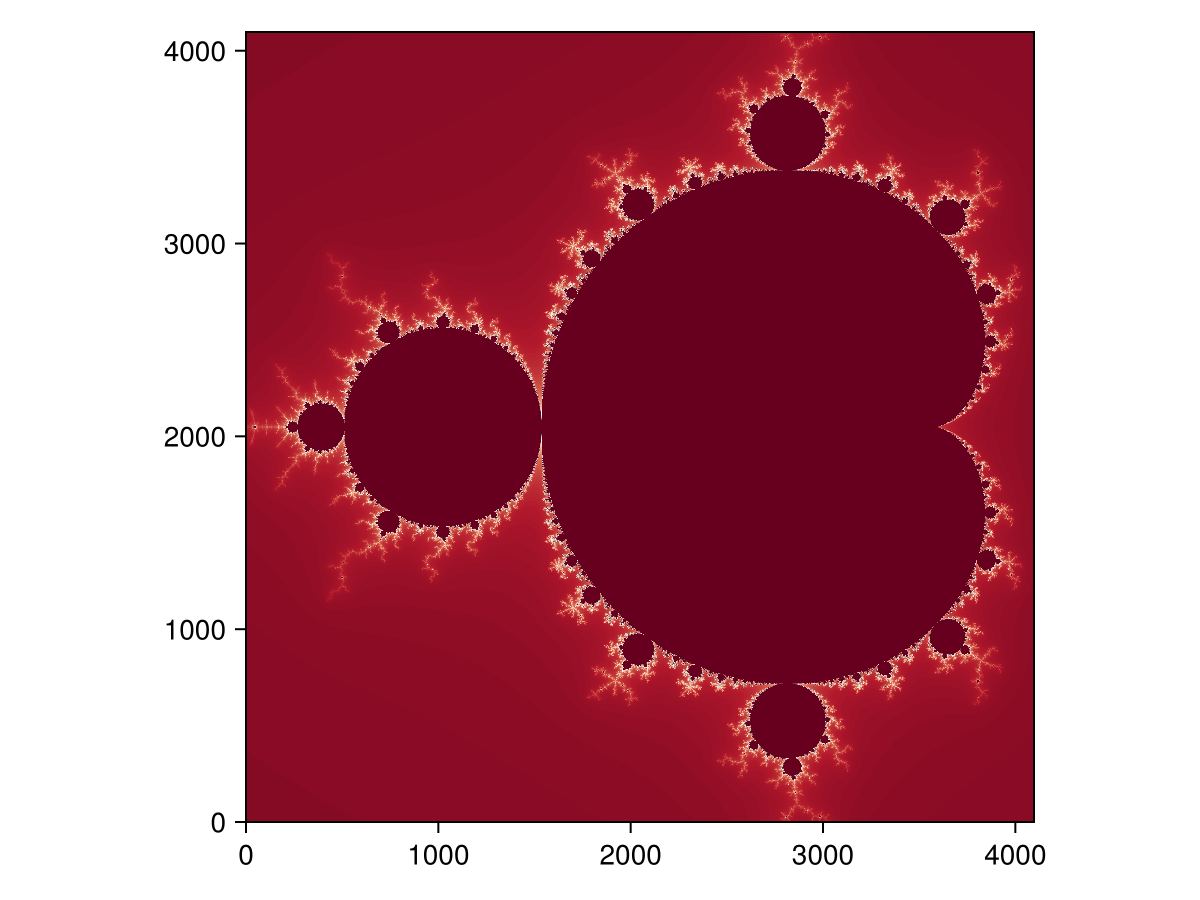

In [6]:
image(rotr90(m), colormap = :RdGy, axis=(aspect = DataAspect(),))

#### Device 1: AMD Ryzen 9 5950X CPU

In [32]:
cl.platform!("pocl")
cl.device()

OpenCL.Device(cpu-haswell-AMD Ryzen 9 5950X 16-Core Processor on Portable Computing Language @0x000000002045b6d0)

In [33]:
@time mandel_opencl(q, 1000);

  1.369612 seconds (83 allocations: 32.005 MiB)


#### Device 2: Intel Arc A770 GPU

In [34]:
cl.platform!("intel")
cl.device()

OpenCL.Device(Intel(R) Arc(TM) A770 Graphics on Intel(R) OpenCL Graphics @0x0000000021715dd0)

In [36]:
@time mandel_opencl(q, 1000);

  0.045864 seconds (80 allocations: 32.005 MiB)


#### Device 3: NVIDIA RTX 6000 Ada GPU

In [37]:
cl.platform!("nvidia")
cl.device()

OpenCL.Device(NVIDIA RTX 6000 Ada Generation on NVIDIA CUDA @0x00000000200c7990)

In [39]:
@time mandel_opencl(q, 1000);

  0.040987 seconds (80 allocations: 32.005 MiB)
